In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install -U tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 14.8 MB/s eta 0:00:00


In [4]:

import os
import cv2
import json
import time
import csv
import requests
from tqdm import tqdm
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.applications.vgg19 import VGG19
from keras.layers import Dropout, Flatten, Dense, Input, MaxPool2D, GlobalAveragePooling2D, Lambda, Conv2D, concatenate, ZeroPadding2D, Layer, MaxPooling2D , Flatten
from keras import backend as K
from keras.models import Model, load_model
import tensorflow_addons as tfa

In [5]:
def get_image_path(path):
  '''
  This function takes the path of the csv file as input and returns a list where each element
  of the list contains a triplet with the path where the actual image is present.
  path(input): path to the csv file for train/test/cv
  img_path: path where we have kept our images
  data_path_lst(output): final list which contains triplet details for input pipeline
  '''
  data_path_lst = []
  
  global img_path 
  with open(path) as csv_file:
    data = csv.reader(csv_file, delimiter = ',')
    for row in data:
      data_path_lst.append([row[0],row[1],row[2]])

  return data_path_lst

In [6]:

def input_parser(input_tensor):
  '''
  
  This function is used as part of data pipeline which reads image path as part of data.Dataset
  and generate the final array for the image using tf.image.decode_jpeg. 3 operations are performed
  in this function. For an image, first we read the path from the input tensor using tf.io.read_file, 
  then we use tf.image.decode_jpeg to decode the image and get a tesnor for the image and finally we
  use tf.image.resize to resize the image as per our architecture.
  input_tensor(input): tensor having image path from where images will be loaded.
  batch_size(input): Number of bacth
  img1(output): containing final tensor for query images
  img2(output): containing final tensor for positive images
  img3(output): containing final tensor for negative images
  '''

  
  imagedir = "/content/drive/MyDrive/visual-search/image/"
  '''
  if "image_pp_background" in input_tensor[1] :
    imgpos = "/content/drive/MyDrive/visual-search/tarkib/"
  else:
    imgpos = "/content/drive/MyDrive/visual-search/PP_image/"
'''
   
  img1 = tf.image.resize(tf.image.decode_jpeg(tf.io.read_file(imagedir+ input_tensor[0]), channels=3), [224, 224])
  img2 = tf.image.resize(tf.image.decode_jpeg(tf.io.read_file( imagedir +input_tensor[1]), channels=3), [224, 224])
  img3 = tf.image.resize(tf.image.decode_jpeg(tf.io.read_file(imagedir+input_tensor[2]), channels=3), [224, 224])

  return img1 , img2 , img3

In [7]:
def input_pipeline(data_path, shuffle_size, batch_size):
  '''
  This function takes in data_path and the batch_size and return final tensors
  representing each of the image.
  data_path(input): final list which contains triplet details for input pipeline
  batch_size(input): number of records for each step
  dataset(output): final dataset object containig tensor of images with a fixed batch size
  '''
  with tf.device('/cpu:0'):
    dataset = tf.data.Dataset.from_tensor_slices((np.array((data_path))))
    dataset = dataset.shuffle(shuffle_size)
    dataset = dataset.map(input_parser, num_parallel_calls = tf.data.experimental.AUTOTUNE)
    dataset = dataset.batch(batch_size).repeat()
    dataset = dataset.prefetch(1)

  return dataset

In [8]:
import tensorflow as tf
from tensorflow.keras import layers

class ChannelAttentionModule(tf.keras.layers.Layer):
    def __init__(self, ch, ratio=8):
        super().__init__()

        self.avg_pool = layers.GlobalAveragePooling2D()
        self.max_pool = layers.GlobalMaxPooling2D()

        self.mlp = tf.keras.Sequential([
            layers.Dense(ch//ratio, use_bias=False),
            layers.ReLU(),
            layers.Dense(ch, use_bias=False)
        ])

        self.sigmoid = layers.Activation('sigmoid')

    def call(self, x):
        """
        x: tensor of shape [batch_size, height, width, channels]
        x1: tensor of shape [batch_size, channels//ratio]
        x2: tensor of shape [batch_size, channels//ratio]
        feats: tensor of shape [batch_size, channels]
        refined_feats: tensor of shape [batch_size, height, width, channels] which is same as input shape.
        
        """


        x1 = self.avg_pool(x)   #(1,128)  14, 14, 128
        x1 = self.mlp(x1)       #(1,128)
        x2 = self.max_pool(x)   #(1,128)
        x2 = self.mlp(x2)       #(1,128)

        feats = x1 + x2          #(1,128)
        feats = self.sigmoid(feats) 

        feats = tf.expand_dims(tf.expand_dims(feats, axis=1), axis=1)
        
        refined_feats = x * feats  #(1,64,64,128) 
        

        return refined_feats






class SpatialAttentionModule(tf.keras.layers.Layer):
    def __init__(self, kernel_size=7):
        super().__init__()

        self.conv = layers.Conv2D(1, kernel_size, padding='same', use_bias=False)
        self.sigmoid = layers.Activation('sigmoid')

    def call(self, inputs):
        """ 
        inputs : tensor of shape [batch_size, height, width, channels]
        x1 : tensor of shape [batch_size, height, width, 1]
        x2 : tensor of shape [batch_size, height, width, 1]
        feats : tensor of shape [batch_size, height, width, 2]
        feats : tensor of shape [batch_size, height, width, 1] where kernel/filter is 7x7
        feats : tensor of shape [batch_size, height, width, 1]
        refined_feats : tensor of shape [batch_size, height, width, channels]
        """




        x1 = tf.reduce_mean(inputs, axis=3, keepdims=True)      #(1,64,64,1)
        x2 = tf.reduce_max(inputs, axis=3, keepdims=True)       #(1,64,64,1)
    
        feats = tf.concat([x1, x2], axis=3)                     #(1,64,64,2)
        feats = self.conv(feats)                                #(1,64,64,1)
        feats = self.sigmoid(feats)
        
        refined_feats = inputs * feats                           #(1,64,64,128)
        
        return refined_feats

class CBAM(tf.keras.layers.Layer):
    def __init__(self, channel):
        super(CBAM, self).__init__()
        self.ca = ChannelAttentionModule(channel)
        self.sa = SpatialAttentionModule()

    def call(self, x):
        
        x = self.ca(x)
        
        x = self.sa(x)
       
        return x

In [9]:
def model_architecture():
    vgg_model = VGG19(weights="imagenet", include_top=False, input_shape=(224,224,3))
    cbam = CBAM(512)(vgg_model.layers[-2].output)
    convnet_output = GlobalAveragePooling2D()(cbam)
    convnet_output = Dense(4096, activation='relu')(convnet_output)
    convnet_output = Dropout(0.5)(convnet_output)
    convnet_output = Dense(4096, activation='relu')(convnet_output)
    convnet_output = Dropout(0.5)(convnet_output)
    y = Lambda(lambda  x: K.l2_normalize(x,axis=1))(convnet_output)

    final_model = tf.keras.models.Model(inputs=[vgg_model.input], outputs=y)

    return final_model
    




In [ ]:
def contrastive_loss_function(q_emd, p_emd, n_emd, batch_size):
    '''
    Ref: https://github.com/gofynd/mildnet/blob/master/trainer/loss.py
    This function takes embedding generated by model for each of the image
    part of the triplet and return the loss value for the batch.
    q_emd(input): embedding generated by model for query image(tensor of size [batch, 4096])
    p_emd(input): embedding generated by model for positive image(tensor of size [batch, 4096])
    n_emd(input): embedding generated by model for negative image(tensor of size [batch, 4096])
    batch_size(input): batch size for each step
    loss(output): Final loss for a batch
    '''
    def _contrastive_loss(y_true, y_pred):
        return tfa.losses.contrastive_loss(y_true, y_pred)

    dist_query_pos = tf.sqrt(tf.reduce_sum((q_emd - p_emd)**2, axis=1))
    dist_query_neg = tf.sqrt(tf.reduce_sum((q_emd - n_emd)**2, axis=1))
    loss_query_pos = _contrastive_loss(tf.ones(batch_size), dist_query_pos)
    loss_query_neg = _contrastive_loss(tf.zeros(batch_size), dist_query_neg)
    loss = tf.reduce_mean(loss_query_pos + loss_query_neg)
    zero = tf.constant(0.0, shape=[1], dtype=tf.float32)
    return tf.maximum(loss, zero)


In [ ]:
def accuracy(q_emd, p_emd, n_emd, batch_size):
  '''
  Ref: https://github.com/gofynd/mildnet/blob/master/trainer/accuracy.py
  This function takes in embedding and return the accuracy value for the batch
  q_emd(input): embedding generated by model for query image(tensor of size [batch, 4096])
  p_emd(input): embedding generated by model for query image(tensor of size [batch, 4096])
  n_emd(input): embedding generated by model for query image(tensor of size [batch, 4096])
  batch_size(input): batch size for each step
  accuracy(output): Final accuracy value for a batch
  '''
  accuracy = 0
  for obs_num in range(batch_size):
    dist_query_pos = tf.sqrt(tf.reduce_sum((q_emd[obs_num] - p_emd[obs_num])**2))
    dist_query_neg = tf.sqrt(tf.reduce_sum((q_emd[obs_num] - n_emd[obs_num])**2))
    accuracy += tf.cond(dist_query_neg > dist_query_pos, lambda : 1, lambda : 0)

  return (accuracy * 100) / batch_size

In [ ]:
@tf.function
def train_step(data, batch_size):
  '''
  This is the custom function which will be responsible for trainig based
  on the training dataset, here we first calculate the embedding for our triplet.
  Then, we'll find the loss and accuracy value using the embedded tensors.
  Finally, we use loss value and gradient tape to calculate the gradients and 
  optimizer to update weights. All of these operations are done for one step and
  we keep on updating weights untill convergence.
  data(input): input tensor
  loss_value(output): loss value for the batch before updating weights
  accuracy_value(output): accuracy value for the batch before updating weights
  '''
  with tf.GradientTape() as tape:
    q_emd = model(data[0], training = True)
    p_emd = model(data[1], training = True)
    n_emd = model(data[2], training = True)

    loss_value = contrastive_loss_function(q_emd, p_emd, n_emd, batch_size)
    accuracy_value = accuracy(q_emd, p_emd, n_emd, batch_size)

  grads = tape.gradient(loss_value, model.trainable_weights)
  optimizer.apply_gradients(zip(grads, model.trainable_weights))
  return loss_value, accuracy_value

In [ ]:

def flow(epochs, batch_size):
  #define path from where data will be read
  train_csv_file = '/content/drive/MyDrive/visual-search/code/train.csv'
  cv_csv_file = '/content/drive/MyDrive/visual-search/code/val_data.csv'
  val_batch_size = 64

  #calling get_image_path to get a list of triplets with actual path
  train_data_path = get_image_path(train_csv_file)
  validation_data_path = get_image_path(cv_csv_file)
  train_loss = tf.metrics.Mean(name="train_loss")
  train_accuracy = tf.metrics.Mean(name="train_acc")

  #Starting the actual flow from where we will start training using our custom function, enabling GPU for training
  with tf.device('/gpu:0'):
    for epoch in range(epochs):
      epoch_start_time = time.time()
      print('*'*100)
      print('Epoch: {}'.format(epoch + 1))
      train_dataset = input_pipeline(train_data_path, len(train_data_path), batch_size) # calling pipeline method to generate train dataset
      train_iterator = iter(train_dataset) # Creating an iterator on the dataset

      train_loss.reset_states()
      train_accuracy.reset_states()
      loss_, acc_ = [], []
      for step in range(len(train_data_path) // batch_size):
      #for step in range(2):
        
        train_data = train_iterator.get_next() #Calling a batch of dataset
        train_loss_value, train_accuracy_value = train_step(train_data, batch_size) # Calling train step function on the fetched batch
        loss_.append(train_loss_value.numpy()[0])
        acc_.append(train_accuracy_value)
        #print(train_loss)

        #Printing loss and accuracy value after every 200 steps in an epoch
        if step % 10 == 0:
          print('\t{} train samples seen so far'.format((step + 1) * batch_size)) 
          print('\tTraining loss(for one batch) at step {} is {}'.format(step + 1, train_loss_value))
          print('\tTraining accuracy(for one batch) at step {} is {}'.format(step + 1, train_accuracy_value))
      
      train_loss.update_state(loss_)
      train_accuracy.update_state(acc_)

      val_accuracy, val_loss = [], []
      validation_dataset = input_pipeline(validation_data_path, len(validation_data_path), val_batch_size)
      validation_iterator = iter(validation_dataset)
      for _ in range(len(validation_data_path) // val_batch_size):
        validation_data = validation_iterator.get_next()
        validation_loss_value, validation_accuracy_value = val_step(validation_data, val_batch_size)
        val_loss.append(validation_loss_value.numpy()[0])
        val_accuracy.append(validation_accuracy_value)
      
      #printing loss and accuracy value after the end of epoch on final batch of that epoch
      print('Train loss after epoch {} is: {}'.format(epoch + 1, train_loss.result().numpy()))
      print('Validation loss after epoch {} is: {}'.format(epoch + 1, round(np.mean(np.array(val_loss)), 6)))
      print('Train Accuracy after epoch {} is: {}'.format(epoch + 1, train_accuracy.result().numpy()))
      print('Validation Accuracy after epoch {} is: {}'.format(epoch + 1, round(np.mean(np.array(val_accuracy)), 2)))
      print('Time taken to complete epoch {} is: {} mins'.format(epoch + 1, round((time.time() - epoch_start_time) / 60, 2)))
      
      # write them to the tensorboard
      with tf.name_scope("per_epoch_params"):
        with wtrain.as_default():
          tf.summary.scalar("loss", train_loss.result().numpy(), step=epoch)
          tf.summary.scalar("acc", train_accuracy.result().numpy(), step=epoch)
          wtrain.flush()

        with wval.as_default():
          tf.summary.scalar("loss", round(np.mean(np.array(val_loss)), 6), step=epoch)
          tf.summary.scalar("acc", round(np.mean(np.array(val_accuracy)), 2), step=epoch)
          wval.flush()
      if epoch % 5 == 0:
        model.save_weights('/content/drive/MyDrive/visual-search/Weight/cbam/epoch{}model.h5'.format(epoch + 1))
        print('Model weights saved!!!!')

In [ ]:
@tf.function
def val_step(data, batch_size):
  '''
  This function is the step function which finds the loss value and the accuracy
  on a bacth of data for each step in an epoch on validation data. No training is
  done within this bock, instead we just find the embedding and based on what model
  has learned in the train phase we get the final loss and accuracy on validation data
  data(input): input tensor
  loss_value(output): loss value for the batch before updating weights
  accuracy_value(output): accuracy value for the batch before updating weights
  '''
  q_emd = model(data[0], training = False)
  p_emd = model(data[1], training = False)
  n_emd = model(data[2], training = False)

  loss_value = contrastive_loss_function(q_emd, p_emd, n_emd, batch_size)
  accuracy_value = accuracy(q_emd, p_emd, n_emd, batch_size)

  return loss_value, accuracy_value

In [ ]:
if __name__ == '__main__':
  #img_path = img_path
  wtrain = tf.summary.create_file_writer(logdir = 'logs/train')
  wval = tf.summary.create_file_writer(logdir = 'logs/val')
  model = model_architecture()
  optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001) #defining optimizer
  flow(20, 8) # 10 epochs, batch size of 32

****************************************************************************************************
Epoch: 1


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


	8 train samples seen so far
	Training loss(for one batch) at step 1 is [1.4704475]
	Training accuracy(for one batch) at step 1 is 75.0
	88 train samples seen so far
	Training loss(for one batch) at step 11 is [1.0333251]
	Training accuracy(for one batch) at step 11 is 50.0
	168 train samples seen so far
	Training loss(for one batch) at step 21 is [1.0040202]
	Training accuracy(for one batch) at step 21 is 62.5
	248 train samples seen so far
	Training loss(for one batch) at step 31 is [1.006028]
	Training accuracy(for one batch) at step 31 is 50.0
	328 train samples seen so far
	Training loss(for one batch) at step 41 is [1.0203403]
	Training accuracy(for one batch) at step 41 is 75.0
	408 train samples seen so far
	Training loss(for one batch) at step 51 is [1.0474029]
	Training accuracy(for one batch) at step 51 is 50.0
	488 train samples seen so far
	Training loss(for one batch) at step 61 is [0.9922879]
	Training accuracy(for one batch) at step 61 is 50.0
	568 train samples seen so

In [10]:
model = model_architecture()
  # calling model architecture function
model.load_weights('/content/drive/MyDrive/visual-search/Weight/cbam/epoch11model.h5') # Loading weights for model saved after 4th epoch

80134624/80134624 [==============================] - 0s 0us/step


In [11]:
def get_image_path(path):
  '''
  This function is used in our case to read the data that we have in our test set
  It will read the test csv file that we have, return 2 separate list, one with 
  query images and other with images that we already have in system.
  '''
  query_image = []
  
  
  
  
  img_path = "/content/drive/MyDrive/visual-search/image/"
  with open(path) as csv_file:
    data = csv.reader(csv_file, delimiter = ',')
    for row in data:
      query_image.append(img_path + row[0])

  return query_image, list(set(query_image))

In [12]:
query_lst, stored_images_list = get_image_path('/content/drive/MyDrive/visual-search/code/orginal_image.csv')


In [13]:
def query_embedding(query_image_path):
  '''
  This function returns image embedding for any query image based on the best model
  weights that are saved during training. 
  '''
  img = tf.image.resize(tf.image.decode_jpeg(tf.io.read_file(query_image_path), channels=3), [224, 224])
  img = tf.reshape(img, [1,224,224,3])
  return model(img)

In [14]:
def parser(input_tensor):
  '''
  This function can be used as a parser function for all the images we have that
  will be recommended to the user when the user will select a query image
  '''
  return tf.image.resize(tf.image.decode_jpeg(tf.io.read_file(input_tensor), channels=3), [224, 224])

In [15]:
def get_saved_images_embedding(data_path, batch_size = 64):
  '''
  This function is used to generate a pipeline that will be used to create a batch.
  Main purpose of having this is to overcome the RAM issue faced since we are using 
  everything on colab, in real world all our images will be stored in a bucket from where
  we can directly read them from their and pass on to model function to generate the 
  embedding which will be stored in a cache DB for low latency
  '''
  dataset = tf.data.Dataset.from_tensor_slices((np.array((data_path))))
  dataset = dataset.map(parser, num_parallel_calls = tf.data.experimental.AUTOTUNE)
  dataset = dataset.batch(batch_size)
  return dataset

In [19]:

query_lst, stored_images_list = get_image_path('/content/drive/MyDrive/visual-search/code/orginal_image.csv')

model = model_architecture() # calling model architecture function
model.load_weights('/content/drive/MyDrive/visual-search/Weight/cbam/epoch11model.h5') # Loading weights for model saved after 4th epoch

saved_images_data = get_saved_images_embedding(stored_images_list)
test_iterator = iter(saved_images_data)
print(test_iterator)
#generating embeddings
test_data_lst = []
for _ in tqdm(range(len(stored_images_list) // 64)):
  test_data = test_iterator.get_next()
  
  test_data_lst.append(model(test_data))
  
final_embedding = tf.concat(test_data_lst, axis = 0)
del test_data_lst

100%|██████████| 8/8 [00:52<00:00,  6.51s/it]


In [20]:
def cosine_distance(x, y):
  '''
  This function inputs 2 vector and calculates cosine distance.
  '''
  return np.dot(x, y)/(np.linalg.norm(x) * np.linalg.norm(y))

In [21]:
def get_neighbours(train, query_embedding, k):
  '''
  This function finds the NN based on the cosine distance, it return top k NNs
  '''
  distance = [(index, cosine_distance(row, query_embedding)) for index, row in enumerate(train)]
  print(f" this is index  and this is distance {distance}")
  distance.sort(key = lambda x : x[1], reverse=True)
  print(f" this is index  and this is distance {distance}")

  return distance[0:k]

In [22]:
import glob

image_lst = glob.glob("/content/drive/MyDrive/visual-search/test/*.jpg")

In [23]:
query_aks = []
nn_lst = []
base_q = '/content/drive/MyDrive/visual-search/orginal_imgs/' 

base_e = '/content/drive/MyDrive/visual-search/test/'
for i in tqdm(range(len(image_lst))):
  img = image_lst[i].split("/")[-1]
  query_aks.append(os.path.join(base_q , img))
  nn_lst.append([(i , 1)] + get_neighbours(final_embedding.numpy(), query_embedding(os.path.join(base_e , img)).numpy()[0], 8))

 17%|█▋        | 1/6 [00:00<00:04,  1.14it/s]

 this is index  and this is distance [(0, 1.0), (1, 1.0000001), (2, 1.0000001), (3, 1.0), (4, 1.0), (5, 1.0), (6, 1.0000001), (7, 1.0), (8, 1.0000001), (9, 0.99999994), (10, 1.0000001), (11, 1.0), (12, 1.0), (13, 1.0), (14, 1.0), (15, 1.0), (16, 1.0), (17, 1.0000001), (18, 1.0), (19, 1.0), (20, 0.99999994), (21, 1.0), (22, 0.99999994), (23, 1.0), (24, 1.0), (25, 1.0), (26, 0.99999994), (27, 1.0000001), (28, 1.0000001), (29, 1.0), (30, 1.0), (31, 1.0), (32, 1.0000001), (33, 1.0), (34, 1.0), (35, 1.0000001), (36, 1.0), (37, 1.0000001), (38, 1.0), (39, 1.0), (40, 1.0), (41, 1.0), (42, 1.0), (43, 1.0000001), (44, 1.0), (45, 1.0), (46, 1.0), (47, 1.0), (48, 1.0000001), (49, 0.99999994), (50, 1.0), (51, 1.0000001), (52, 1.0), (53, 1.0), (54, 1.0), (55, 1.0000001), (56, 1.0000001), (57, 1.0), (58, 1.0), (59, 1.0), (60, 1.0), (61, 1.0000001), (62, 1.0000001), (63, 1.0), (64, 1.0000001), (65, 1.0), (66, 1.0), (67, 0.99999994), (68, 1.0000001), (69, 1.0), (70, 1.0), (71, 1.0), (72, 1.0), (73, 1.

 33%|███▎      | 2/6 [00:01<00:01,  2.04it/s]

 this is index  and this is distance [(0, 1.0), (1, 1.0), (2, 0.99999994), (3, 1.0), (4, 1.0000001), (5, 1.0), (6, 1.0), (7, 1.0), (8, 1.0000001), (9, 1.0000001), (10, 0.99999994), (11, 1.0), (12, 0.99999994), (13, 1.0), (14, 0.99999994), (15, 1.0), (16, 0.99999994), (17, 1.0000001), (18, 0.9999999), (19, 1.0), (20, 1.0), (21, 1.0), (22, 1.0), (23, 1.0), (24, 1.0), (25, 1.0), (26, 1.0), (27, 1.0000001), (28, 1.0), (29, 1.0), (30, 1.0), (31, 0.99999994), (32, 1.0), (33, 1.0), (34, 1.0), (35, 1.0), (36, 1.0000001), (37, 1.0000001), (38, 1.0), (39, 1.0), (40, 1.0), (41, 1.0), (42, 0.99999994), (43, 1.0), (44, 1.0), (45, 1.0), (46, 1.0), (47, 0.9999999), (48, 1.0000001), (49, 0.99999994), (50, 1.0), (51, 1.0), (52, 1.0), (53, 0.99999994), (54, 0.9999999), (55, 1.0), (56, 1.0000001), (57, 1.0), (58, 0.99999994), (59, 1.0), (60, 1.0), (61, 0.99999994), (62, 1.0000001), (63, 1.0), (64, 1.0), (65, 0.99999994), (66, 1.0), (67, 0.99999994), (68, 1.0), (69, 1.0), (70, 1.0), (71, 1.0), (72, 1.0), 

 50%|█████     | 3/6 [00:01<00:01,  2.39it/s]

 this is index  and this is distance [(0, 1.0), (1, 1.0000001), (2, 1.0000001), (3, 1.0000001), (4, 1.0000001), (5, 1.0), (6, 1.0000001), (7, 1.0), (8, 1.0000001), (9, 1.0000001), (10, 1.0000001), (11, 1.0000001), (12, 1.0000001), (13, 1.0), (14, 1.0), (15, 1.0000001), (16, 1.0), (17, 1.0000001), (18, 1.0000001), (19, 1.0000001), (20, 1.0), (21, 1.0), (22, 1.0), (23, 1.0), (24, 1.0000001), (25, 1.0), (26, 1.0), (27, 1.0000002), (28, 1.0000001), (29, 1.0), (30, 1.0000001), (31, 1.0), (32, 1.0000001), (33, 1.0000001), (34, 1.0000001), (35, 1.0000001), (36, 1.0000001), (37, 1.0000001), (38, 1.0000001), (39, 1.0), (40, 1.0000001), (41, 1.0000001), (42, 1.0), (43, 1.0000001), (44, 1.0), (45, 1.0), (46, 1.0), (47, 1.0), (48, 1.0000001), (49, 1.0000001), (50, 1.0000001), (51, 1.0000001), (52, 1.0000001), (53, 1.0000001), (54, 1.0), (55, 1.0000001), (56, 1.0000001), (57, 1.0000001), (58, 1.0), (59, 1.0), (60, 1.0), (61, 1.0000001), (62, 1.0000001), (63, 1.0), (64, 1.0), (65, 1.0), (66, 1.0), (

 67%|██████▋   | 4/6 [00:01<00:00,  2.86it/s]

 this is index  and this is distance [(0, 1.0000001), (1, 1.0000001), (2, 1.0), (3, 1.0000001), (4, 1.0000001), (5, 1.0000001), (6, 1.0000001), (7, 1.0000001), (8, 1.0000001), (9, 1.0000001), (10, 1.0000001), (11, 1.0000001), (12, 1.0000001), (13, 1.0000001), (14, 1.0), (15, 1.0000001), (16, 1.0000001), (17, 1.0), (18, 1.0), (19, 1.0000001), (20, 1.0), (21, 1.0000001), (22, 1.0000001), (23, 1.0000001), (24, 1.0000001), (25, 1.0), (26, 1.0000001), (27, 1.0000001), (28, 1.0000001), (29, 1.0000001), (30, 1.0000001), (31, 0.99999994), (32, 1.0000001), (33, 1.0000001), (34, 1.0000001), (35, 1.0000001), (36, 1.0000001), (37, 1.0), (38, 1.0000001), (39, 1.0000001), (40, 1.0000001), (41, 1.0000001), (42, 1.0), (43, 1.0000001), (44, 1.0000001), (45, 1.0000001), (46, 1.0000001), (47, 1.0), (48, 1.0000001), (49, 1.0), (50, 1.0000001), (51, 1.0000001), (52, 1.0000001), (53, 1.0000001), (54, 1.0), (55, 1.0000001), (56, 1.0000001), (57, 1.0000001), (58, 1.0), (59, 1.0000001), (60, 1.0000001), (61, 1

 83%|████████▎ | 5/6 [00:01<00:00,  3.27it/s]

 this is index  and this is distance [(0, 1.0000001), (1, 1.0000001), (2, 1.0000001), (3, 1.0000002), (4, 1.0000001), (5, 1.0000001), (6, 1.0000001), (7, 1.0), (8, 1.0000001), (9, 1.0000001), (10, 1.0000001), (11, 1.0000001), (12, 1.0000001), (13, 1.0), (14, 1.0), (15, 1.0000001), (16, 1.0), (17, 1.0), (18, 1.0), (19, 1.0000001), (20, 1.0000001), (21, 1.0000001), (22, 1.0000001), (23, 1.0000001), (24, 1.0000001), (25, 0.99999994), (26, 1.0000001), (27, 1.0000001), (28, 1.0000001), (29, 1.0000001), (30, 1.0), (31, 1.0000001), (32, 1.0000001), (33, 1.0000001), (34, 1.0000001), (35, 1.0000001), (36, 1.0000001), (37, 1.0000001), (38, 1.0000001), (39, 1.0000001), (40, 1.0000001), (41, 1.0000001), (42, 1.0000001), (43, 1.0000001), (44, 1.0000001), (45, 1.0000001), (46, 1.0000001), (47, 1.0000001), (48, 1.0000001), (49, 1.0000001), (50, 1.0000001), (51, 1.0000001), (52, 1.0000001), (53, 1.0000001), (54, 1.0000001), (55, 1.0000001), (56, 1.0000001), (57, 1.0000001), (58, 1.0), (59, 1.0000001),

100%|██████████| 6/6 [00:02<00:00,  2.78it/s]

 this is index  and this is distance [(0, 1.0), (1, 1.0000001), (2, 1.0), (3, 1.0000001), (4, 1.0), (5, 1.0), (6, 0.99999994), (7, 1.0), (8, 1.0000001), (9, 1.0000001), (10, 1.0000001), (11, 1.0), (12, 1.0), (13, 1.0), (14, 1.0), (15, 1.0000001), (16, 1.0), (17, 1.0), (18, 0.9999999), (19, 1.0), (20, 1.0), (21, 1.0), (22, 1.0), (23, 1.0), (24, 1.0), (25, 0.99999994), (26, 1.0), (27, 1.0000001), (28, 1.0000001), (29, 1.0), (30, 1.0), (31, 1.0), (32, 1.0), (33, 1.0), (34, 1.0), (35, 1.0), (36, 1.0000001), (37, 1.0), (38, 1.0), (39, 1.0), (40, 1.0), (41, 1.0), (42, 1.0), (43, 1.0), (44, 1.0), (45, 1.0), (46, 1.0), (47, 1.0), (48, 1.0000001), (49, 1.0), (50, 1.0), (51, 1.0), (52, 1.0), (53, 1.0), (54, 1.0), (55, 1.0000001), (56, 1.0000001), (57, 1.0), (58, 1.0), (59, 1.0), (60, 1.0), (61, 1.0), (62, 1.0000001), (63, 1.0), (64, 1.0), (65, 1.0), (66, 1.0), (67, 0.99999994), (68, 1.0), (69, 1.0), (70, 1.0), (71, 1.0), (72, 1.0), (73, 1.0), (74, 1.0000001), (75, 1.0), (76, 1.0000001), (77, 1.0

In [24]:
nn_name = []

for items in nn_lst:
  nn_name.append(query_aks[items[0][0]])

  
  for index in range(6):
    nn_name.append(stored_images_list[items[index+1][0]])
    print(items[index+1][0])
    print(stored_images_list[items[index+1][0]])



1
/content/drive/MyDrive/visual-search/image/Image 1928.jpg
2
/content/drive/MyDrive/visual-search/image/Image 1613.jpg
6
/content/drive/MyDrive/visual-search/image/Image 1479.jpg
8
/content/drive/MyDrive/visual-search/image/Image 774.jpg
10
/content/drive/MyDrive/visual-search/image/Image 1247.jpg
17
/content/drive/MyDrive/visual-search/image/Image 450.jpg
4
/content/drive/MyDrive/visual-search/image/Image 530.jpg
8
/content/drive/MyDrive/visual-search/image/Image 774.jpg
9
/content/drive/MyDrive/visual-search/image/Image 1040.jpg
17
/content/drive/MyDrive/visual-search/image/Image 450.jpg
27
/content/drive/MyDrive/visual-search/image/Image 1410.jpg
36
/content/drive/MyDrive/visual-search/image/Image 1381.jpg
27
/content/drive/MyDrive/visual-search/image/Image 1410.jpg
254
/content/drive/MyDrive/visual-search/image/Image 1907.jpg
1
/content/drive/MyDrive/visual-search/image/Image 1928.jpg
2
/content/drive/MyDrive/visual-search/image/Image 1613.jpg
3
/content/drive/MyDrive/visual-searc

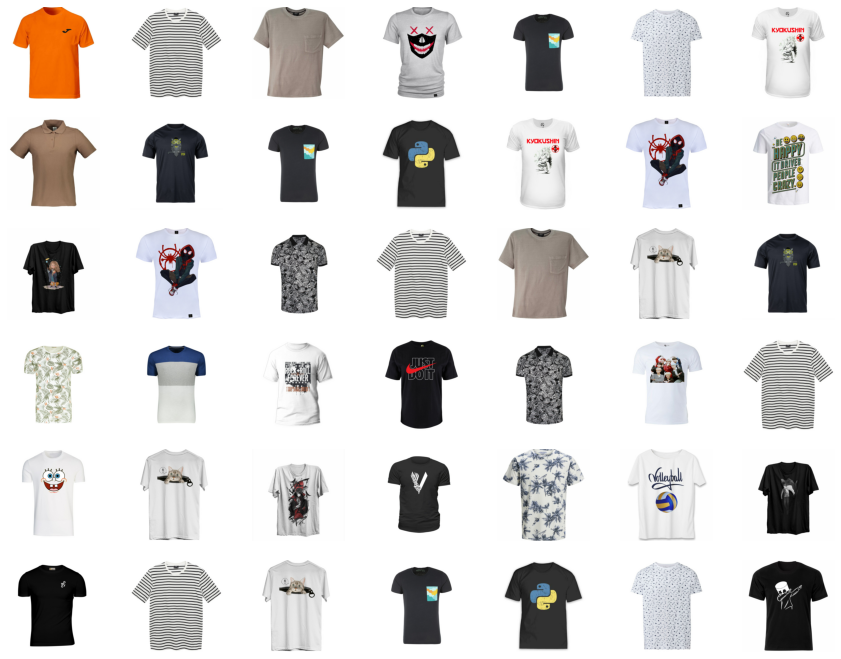

In [25]:
from random import shuffle
fig=plt.figure(figsize=(15, 20))
#shuffle(nn_lst) # Shuffling list
subplot_index = 1 #Creating an index element for sub plots

for items in nn_name:
   #choosing 10 samples

  
  
    
    img = tf.image.decode_jpeg(tf.io.read_file(items), channels=3)
    fig.add_subplot(10, 7, subplot_index)
    plt.axis('off')
    plt.imshow(img)
    subplot_index += 1

plt.axis('off')
plt.show()
#First image is the query image and the next 5 images are the result model gave...

#fig.savefig("...,.png")